In [1]:
import subprocess
import os
import logging
import re
import itertools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
from collections import defaultdict

# Add path to hicreppy

In [2]:
environment_name = 'hicreppy'
environment_path = f"/users/michael.mitter/.conda/envs/{ environment_name }/bin/"

# get pre-set PATH environment variable
original_os_path = os.environ.get('PATH')
os_path = original_os_path

# guard PATH against multiple prepending
if environment_path not in original_os_path:
    os_path = environment_path + ':' + original_os_path
%env PATH=$os_path

env: PATH=/users/michael.mitter/.conda/envs/hicreppy/bin/:/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/users/michael.mitter/.vscode-server/bin/5763d909d5f12fe19f215cbfdd29a91c0fa9208a/bin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/users/michael.mitter/.vscode-server/bin/5763d909d5f12fe19f215cbfdd29a91c0fa9208a/bin:/software/2020/software/anaconda3/2019.03/condabin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/software/system/utils:/usr/local/bin:/usr/bin:/groups/gerlich/members/MichaelMitter/UCSC_usertools/:/groups/gerlich/members/MichaelMitter/PythonPackages/OnTAD/:/usr/local/sb

# Define plotting parameters

In [3]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define Samples

In [4]:
def runSCC(fileIterator, binSize, maxdist=100000, subsample=0):
    """runs hicreppy scc on a pair of file returned
    by fileIterator for files located in fileDir."""
    # dispatch processes
    processList = []
    for file1, file2 in fileIterator:
        mat1 = f"{file1}::/resolutions/{binSize}"
        mat2 = f"{file2}::/resolutions/{binSize}"
        command = f"hicreppy scc -m {maxdist} -s {subsample} {mat1} {mat2}"
        processList.append((file1, file2, subprocess.Popen(command, stdout=subprocess.PIPE,
                                                           stderr=subprocess.STDOUT, shell=True)))
    # query if processes are finished and store results in list
    resultList = []
    while len(processList) != 0:
        for index, p in enumerate(processList):
            result = p[2].poll()
            if result is not None:
                output, err = p[2].communicate()
                for line in output.decode("UTF-8").split("\n"):
                    logging.info(line)
                    try:
                        value = float(line.strip())
                    except ValueError:
                        pass
                    else:
                        barcode1 = p[0].split("/")[-1].split(".1000.mcool")[0]
                        barcode2 = p[1].split("/")[-1].split(".1000.mcool")[0]
                        resultList.append(
                            {"barcode1": barcode1, "barcode2": barcode2, "sccR": value})
                logging.info("\n\n")
                processList.pop(index)
    return pd.DataFrame(resultList)

def recDict():
    return defaultdict(recDict)

# Define HiC samples

In [5]:
sampleFiles = {}
for rType in ["cis", "trans", "all"]:
    sampleFiles[rType] = []

In [6]:
HICDIR1 = "/groups/gerlich/experiments/Experiments_004800/004869/Sequencing_data/Pooled/cooler"

barcodes = ["CAGATC", "ACTTGA"]

for barcode in barcodes:
    for rType in ["cis", "trans", "all"]:
        tempFile = os.path.join(HICDIR1, f"{barcode}.{rType}.1000.mcool")
        sampleFiles[rType].append(tempFile)

In [7]:
HICDIR2 = "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/Novaseq/cooler/"

barcodes = ["GGCTAC", "GTGAAA"]

for barcode in barcodes:
    for rType in ["cis", "trans", "all"]:
        tempFile = os.path.join(HICDIR2, f"{barcode}.{rType}.1000.mcool")
        sampleFiles[rType].append(tempFile)

# Define HiCRep parameters

In [8]:
maxdist = 1000000

# Compare files

In [9]:
allFilesComb = itertools.combinations(sampleFiles["all"], r=2)
allResultsAll = runSCC(allFilesComb, 100000, maxdist, subsample=0)
allResultsAll.loc[:, "type"] = "all"
allResultsAll.loc[:, "maxdist"] = maxdist

In [10]:
cisFilesComb = itertools.combinations(sampleFiles["cis"],r=2)
cisResultsAll = runSCC(cisFilesComb, 100000, maxdist, subsample=0)
cisResultsAll.loc[:, "type"] = "cis"
cisResultsAll.loc[:, "maxdist"] = maxdist

In [11]:
transFilesComb = itertools.combinations(sampleFiles["trans"], r=2)
transResultsAll = runSCC(transFilesComb, 100000, maxdist, subsample=0)
transResultsAll.loc[:, "type"] = "trans"
transResultsAll.loc[:, "maxdist"] = maxdist

In [12]:
cisTransFilesComb = itertools.product(sampleFiles["cis"], sampleFiles["trans"])
cisTransResultsAll = runSCC(cisTransFilesComb, 100000, maxdist, subsample=0)
cisTransResultsAll.loc[:, "type"] = "cis/trans"
cisTransResultsAll.loc[:, "maxdist"] = maxdist

In [13]:
finFrameAll = pd.concat((cisResultsAll, transResultsAll, cisTransResultsAll, allResultsAll))
finFrameAll

,barcode1,barcode2,sccR,type,maxdist
0,GGCTAC.cis,GTGAAA.cis,0.900601,cis,1000000
1,ACTTGA.cis,GTGAAA.cis,0.962313,cis,1000000
2,ACTTGA.cis,GGCTAC.cis,0.948291,cis,1000000
3,CAGATC.cis,GGCTAC.cis,0.951933,cis,1000000
4,CAGATC.cis,GTGAAA.cis,0.958662,cis,1000000
5,CAGATC.cis,ACTTGA.cis,0.995364,cis,1000000
0,GGCTAC.trans,GTGAAA.trans,0.827684,trans,1000000
1,ACTTGA.trans,GGCTAC.trans,0.885088,trans,1000000
2,ACTTGA.trans,GTGAAA.trans,0.899438,trans,1000000
3,CAGATC.trans,GTGAAA.trans,0.895498,trans,1000000


## Plot

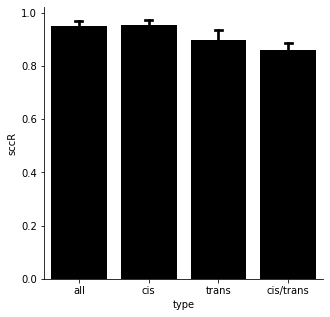

In [14]:
f, ax = plt.subplots()
#sbn.swarmplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=0.2, order=["all", "cis", "trans", "cis/trans"])
sbn.barplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=1, order=["all", "cis", "trans", "cis/trans"], errcolor="black", capsize=0.1)
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

## Write to file

In [28]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl"
f.savefig(os.path.join(resultsdir, "HiC_Rep_Nipbl.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_Nipbl.pdf"), bbox_inches="tight")

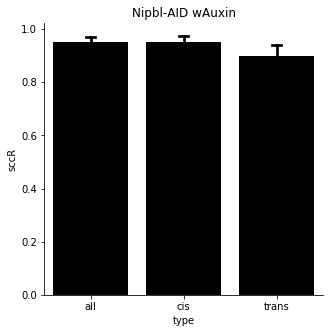

In [18]:
f, ax = plt.subplots()
#sbn.swarmplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=0.2, order=["all", "cis", "trans", "cis/trans"])
sbn.barplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", errcolor="black", capsize=0.1, order=["all", "cis", "trans"])
sbn.despine()
ax.set(title="Nipbl-AID wAuxin")
f.set_size_inches(5, 5)
plt.show()

In [20]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_Nipbl.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_Nipbl.pdf"), bbox_inches="tight")

# Plot barplots with individual points

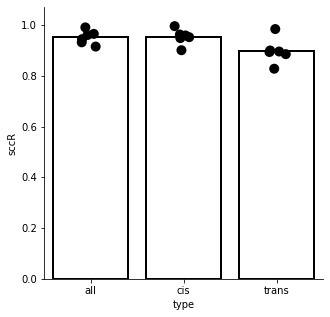

In [16]:
f, ax = plt.subplots()
sbn.barplot(x="type", y="sccR", data=finFrameAll.loc[finFrameAll["type"] != "cis/trans", :], ax=ax, color="black",facecolor=(1, 1, 1, 0) , linewidth=2,edgecolor="black", order=["all", "cis", "trans"], ci=None)
sbn.stripplot(x="type", y="sccR", data=finFrameAll.loc[finFrameAll["type"] != "cis/trans", :], color="black", size=10, jitter=0.1, ax=ax, order=["all", "cis", "trans"])
sbn.despine()
sbn.despine()
f.set_size_inches(5, 5)
plt.show()

In [17]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_Nipbl_indSamples.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_Nipbl_indSamples.pdf"), bbox_inches="tight")